# Customer Churn Prediction with XGBoost
_**Using Gradient Boosted Trees to Predict Mobile Customer Departure**_

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
  1. [Relative cost of errors](#Relative-cost-of-errors)
1. [Extensions](#Extensions)

---

## Background

_This notebook has been adapted from an [AWS blog post](https://aws.amazon.com/blogs/ai/predicting-customer-churn-with-amazon-machine-learning/)_

Losing customers is costly for any business.  Identifying unhappy customers early on gives you a chance to offer them incentives to stay.  This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

We use an example of churn that is familiar to all of us–leaving a mobile phone operator.  Seems like I can always find fault with my provider du jour! And if my provider knows that I’m thinking of leaving, it can offer timely incentives–I can always use a phone upgrade or perhaps have a new feature activated–and I might just stick around. Incentives are often much more cost effective than losing and reacquiring a customer.

---

## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
bucket = 'ndd-reinvent-data'
prefix = 'sagemaker/DEMO-xgboost-churn-1Million'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer

---
## Data

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.  Let's download and read that dataset in now:

In [3]:
!wget https://s3-ap-southeast-2.amazonaws.com/ndd-reinvent-data/1Million.csv

--2018-11-22 03:39:57--  https://s3-ap-southeast-2.amazonaws.com/ndd-reinvent-data/1Million.csv
Resolving s3-ap-southeast-2.amazonaws.com (s3-ap-southeast-2.amazonaws.com)... 52.95.131.25
Connecting to s3-ap-southeast-2.amazonaws.com (s3-ap-southeast-2.amazonaws.com)|52.95.131.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45909011 (44M) [text/csv]
Saving to: ‘1Million.csv’

1Million.csv        100%[===================>]  43.78M  73.9MB/s    in 0.6s    

2018-11-22 03:39:57 (73.9 MB/s) - ‘1Million.csv’ saved [45909011/45909011]



In [4]:
churn = pd.read_csv('1Million.csv')
pd.set_option('display.max_columns', 10)
churn

,PlayerID,Level,Score,Units,Gold,Potions,Friends,InvItems,Fraud?
0,11822,2,882,19,259,42,24,16,True.
1,49012,2,681,26,158,21,24,11,True.
2,12029,1,60,10,5,3,7,4,False.
3,16426,1,317,9,6,5,0,7,False.
4,49860,1,272,10,6,4,6,4,False.
5,30464,1,234,8,6,5,3,5,False.
6,26022,1,138,12,7,7,13,4,False.
7,15658,1,313,9,5,5,17,6,False.
8,45122,1,194,7,10,7,3,2,False.
9,23680,2,402,25,310,36,18,17,True.


By modern standards, it’s a relatively small dataset, with only 3,333 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

- `State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- `Account Length`: the number of days that this account has been active
- `Area Code`: the three-digit area code of the corresponding customer’s phone number
- `Phone`: the remaining seven-digit phone number
- `Int’l Plan`: whether the customer has an international calling plan: yes/no
- `VMail Plan`: whether the customer has a voice mail feature: yes/no
- `VMail Message`: presumably the average number of voice mail messages per month
- `Day Mins`: the total number of calling minutes used during the day
- `Day Calls`: the total number of calls placed during the day
- `Day Charge`: the billed cost of daytime calls
- `Eve Mins, Eve Calls, Eve Charge`: the billed cost for calls placed during the evening
- `Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime
- `Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls
- `CustServ Calls`: the number of calls placed to Customer Service
- `Churn?`: whether the customer left the service: true/false

The last attribute, `Churn?`, is known as the target attribute–the attribute that we want the ML model to predict.  Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Let's begin exploring the data:

col_0,% observations
Fraud?,
False.,0.740528
True.,0.259472


,PlayerID,Level,Score,Units,Gold,Potions,Friends,InvItems
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,30010.825102,13.258686,18464.839554,109.736400,768.833408,149.162399,168.850907,105.246292
std,11550.310362,8.066931,27601.084239,96.115621,1474.434109,199.865610,104.381029,111.131314
min,10000.000000,1.000000,6.000000,7.000000,5.000000,2.000000,0.000000,2.000000
25%,20001.000000,6.000000,2461.000000,46.000000,43.000000,37.000000,82.000000,36.000000
50%,30030.000000,13.000000,8846.000000,84.000000,81.000000,73.000000,160.000000,70.000000
75%,40016.000000,19.000000,20960.000000,131.000000,275.000000,124.000000,244.000000,114.000000
max,49999.000000,48.000000,384063.000000,735.000000,9984.000000,1500.000000,697.000000,844.000000


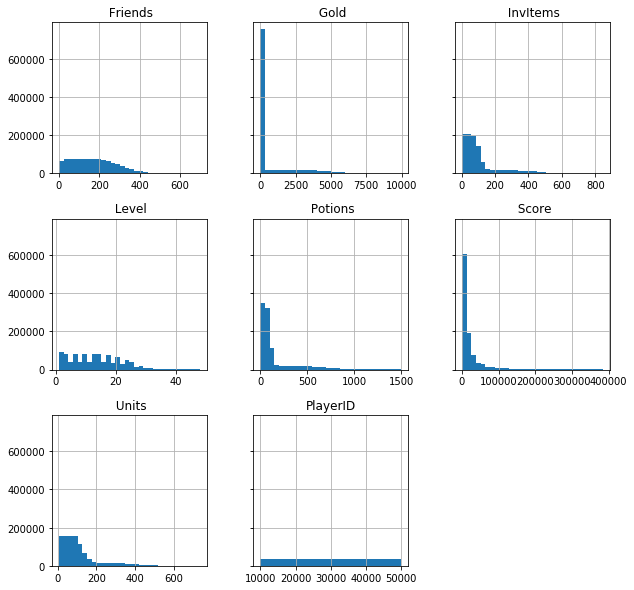

In [5]:
# Frequency tables for each categorical feature
for column in churn.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=churn[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

We can see immediately that:
- `State` appears to be quite evenly distributed
- `Phone` takes on too many unique values to be of any practical use.  It's possible parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it.
- Only 14% of customers churned, so there is some class imabalance, but nothing extreme.
- Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity.  `VMail Message` being a notable exception (and `Area Code` showing up as a feature we should convert to non-numeric).

In [7]:
churn.columns = ['PlayerID', 'Level', 'Score', 'Units', 'Gold', 'Potions', 'Friends', 'InvItems', 'Fraud?']

Next let's look at the relationship between each of the features and our target variable.

PlayerID


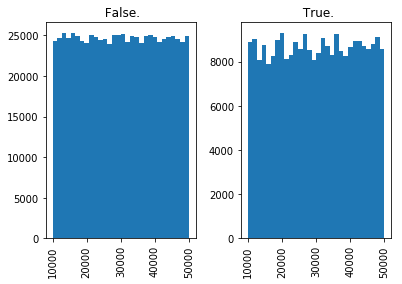

Level


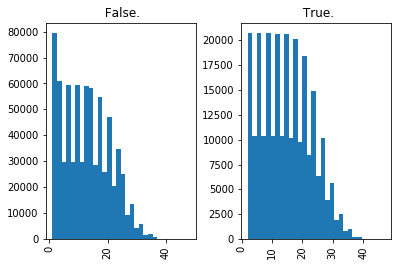

Score


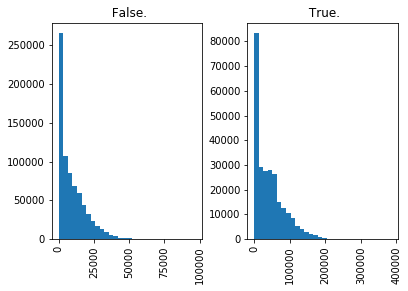

Units


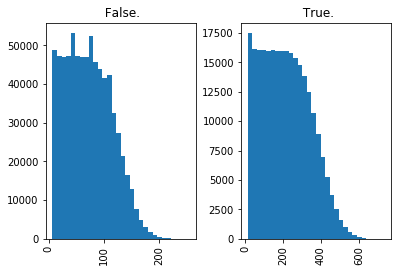

Gold


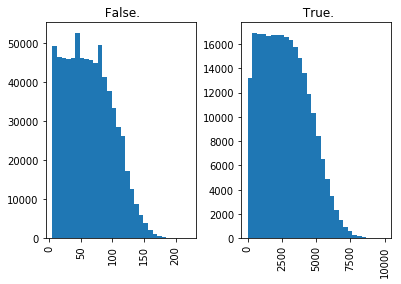

Potions


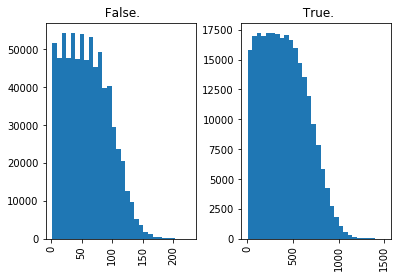

Friends


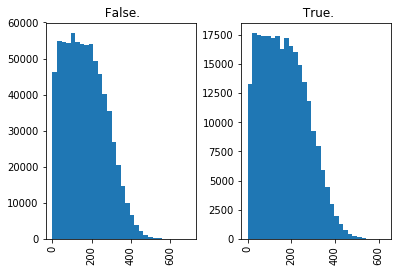

InvItems


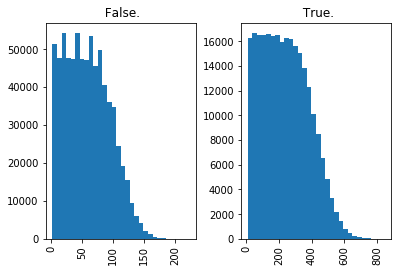

In [8]:
for column in churn.select_dtypes(include=['object']).columns:
    if column != 'Fraud?':
        display(pd.crosstab(index=churn[column], columns=churn['Fraud?'], normalize='columns'))

for column in churn.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = churn[[column, 'Fraud?']].hist(by='Fraud?', bins=30)
    plt.show()

Interestingly we see that churners appear:
- Fairly evenly distributed geographically
- More likely to have an international plan
- Less likely to have a voicemail plan
- To exhibit some bimodality in daily minutes (either higher or lower than the average for non-churners)
- To have a larger number of customer service calls (which makes sense as we'd expect customers who experience lots of problems may be more likely to churn)

In addition, we see that churners take on very similar distributions for features like `Day Mins` and `Day Charge`.  That's not surprising as we'd expect minutes spent talking to correlate with charges.  Let's dig deeper into the relationships between our features.

,PlayerID,Level,Score,Units,Gold,Potions,Friends,InvItems
PlayerID,1.000000,0.001234,0.003381,0.003212,0.004663,0.003737,0.001201,0.003790
Level,0.001234,1.000000,0.675295,0.707154,0.385572,0.515340,0.956663,0.628364
Score,0.003381,0.675295,1.000000,0.953155,0.876629,0.922334,0.602458,0.947293
Units,0.003212,0.707154,0.953155,1.000000,0.909398,0.957508,0.628243,0.983501
Gold,0.004663,0.385572,0.876629,0.909398,1.000000,0.971178,0.300717,0.943935
Potions,0.003737,0.515340,0.922334,0.957508,0.971178,1.000000,0.431098,0.976995
Friends,0.001201,0.956663,0.602458,0.628243,0.300717,0.431098,1.000000,0.546365
InvItems,0.003790,0.628364,0.947293,0.983501,0.943935,0.976995,0.546365,1.000000


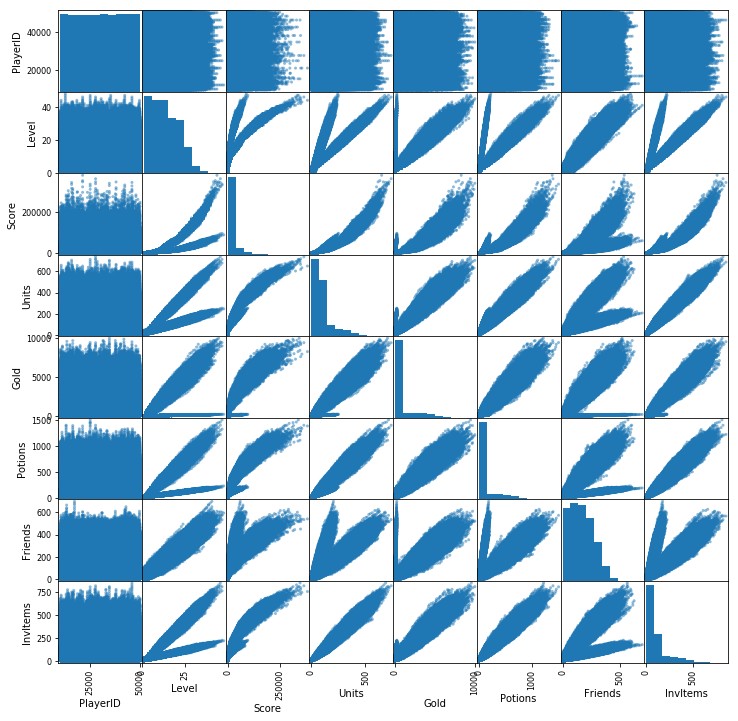

In [9]:
display(churn.corr())
pd.plotting.scatter_matrix(churn, figsize=(12, 12))
plt.show()

We see several features that essentially have 100% correlation with one another.  Including these feature pairs in some machine learning algorithms can create catastrophic problems, while in others it will only introduce minor redundancy and bias.  Let's remove one feature from each of the highly correlated pairs: Day Charge from the pair with Day Mins, Night Charge from the pair with Night Mins, Intl Charge from the pair with Intl Mins:

In [10]:
churn

,PlayerID,Level,Score,Units,Gold,Potions,Friends,InvItems,Fraud?
0,11822,2,882,19,259,42,24,16,True.
1,49012,2,681,26,158,21,24,11,True.
2,12029,1,60,10,5,3,7,4,False.
3,16426,1,317,9,6,5,0,7,False.
4,49860,1,272,10,6,4,6,4,False.
5,30464,1,234,8,6,5,3,5,False.
6,26022,1,138,12,7,7,13,4,False.
7,15658,1,313,9,5,5,17,6,False.
8,45122,1,194,7,10,7,3,2,False.
9,23680,2,402,25,310,36,18,17,True.


Now that we've cleaned up our dataset, let's determine which algorithm to use.  As mentioned above, there appear to be some variables where both high and low (but not intermediate) values are predictive of churn.  In order to accommodate this in an algorithm like linear regression, we'd need to generate polynomial (or bucketed) terms.  Instead, let's attempt to model this problem using gradient boosted trees.  Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint.  XGBoost uses gradient boosted trees which naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format.  For this example, we'll stick with CSV.  It should:
- Have the predictor variable in the first column
- Not have a header row

But first, let's convert our categorical features into numeric features.

In [11]:
model_data = pd.get_dummies(churn)
model_data

,PlayerID,Level,Score,Units,Gold,Potions,Friends,InvItems,Fraud?_ False.,Fraud?_ True.
0,11822,2,882,19,259,42,24,16,0,1
1,49012,2,681,26,158,21,24,11,0,1
2,12029,1,60,10,5,3,7,4,1,0
3,16426,1,317,9,6,5,0,7,1,0
4,49860,1,272,10,6,4,6,4,1,0
5,30464,1,234,8,6,5,3,5,1,0
6,26022,1,138,12,7,7,13,4,1,0
7,15658,1,313,9,5,5,17,6,1,0
8,45122,1,194,7,10,7,3,2,1,0
9,23680,2,402,25,310,36,18,17,0,1


In [12]:
model_data = pd.concat([model_data['Fraud?_ True.'], model_data.drop(['Fraud?_ False.', 'Fraud?_ True.'], axis=1)], axis=1)
model_data

,Fraud?_ True.,PlayerID,Level,Score,Units,Gold,Potions,Friends,InvItems
0,1,11822,2,882,19,259,42,24,16
1,1,49012,2,681,26,158,21,24,11
2,0,12029,1,60,10,5,3,7,4
3,0,16426,1,317,9,6,5,0,7
4,0,49860,1,272,10,6,4,6,4
5,0,30464,1,234,8,6,5,3,5
6,0,26022,1,138,12,7,7,13,4
7,0,15658,1,313,9,5,5,17,6
8,0,45122,1,194,7,10,7,3,2
9,1,23680,2,402,25,310,36,18,17


And now let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [13]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

Now we'll upload these files to S3.

In [14]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

In [15]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3.

In [16]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [17]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.4xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

INFO:sagemaker:Creating training-job with name: xgboost-2018-11-22-03-57-35-817


2018-11-22 03:57:35 Starting - Starting the training job...
2018-11-22 03:57:51 Starting - Launching requested ML instances......
2018-11-22 03:58:55 Starting - Preparing the instances for training.........
2018-11-22 04:00:16 Downloading - Downloading input data..
Arguments: train
[2018-11-22:04:00:44:INFO] Running standalone xgboost training.
[2018-11-22:04:00:44:INFO] File size need to be processed in the node: 28.47mb. Available memory size in the node: 8397.03mb
[2018-11-22:04:00:44:INFO] Determined delimiter of CSV input is ','
[04:00:44] S3DistributionType set as FullyReplicated
[04:00:44] 700000x8 matrix with 5600000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-11-22:04:00:44:INFO] Determined delimiter of CSV input is ','
[04:00:44] S3DistributionType set as FullyReplicated
[04:00:44] 200000x8 matrix with 1600000 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[04:00:45] src/tree/updater_prune.c

[04:01:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=2
[66]#011train-error:6e-05#011validation-error:0.00011
[04:01:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[67]#011train-error:6e-05#011validation-error:0.00011
[04:01:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[68]#011train-error:6e-05#011validation-error:0.00011
[04:01:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[69]#011train-error:6e-05#011validation-error:0.00011
[04:01:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[70]#011train-error:5.9e-05#011validation-error:0.00011
[04:01:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[71]#011train-error:5.9e-05#011validation-error:0.000105


---
## Host

Now that we've trained the algorithm, let's create a model and deploy it to a hosted endpoint.

In [18]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.4xlarge')

INFO:sagemaker:Creating model with name: xgboost-2018-11-22-04-01-48-866
INFO:sagemaker:Creating endpoint with name xgboost-2018-11-22-03-57-35-817


-----------------------------------------------------------------------------!

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [19]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [20]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.as_matrix()[:, 1:])

In [25]:
predictions

array([9.99985099e-01, 9.99991059e-01, 6.02993487e-06, ...,
       5.26921121e-06, 1.74918459e-05, 4.81643838e-05])

There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values.  In this case, we're simply predicting whether the customer churned (`1`) or not (`0`), which produces a simple confusion matrix.

In [21]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,73844,3
1,4,26149


_Note, due to randomized elements of the algorithm, you results may differ slightly._

Of the 48 churners, we've correctly predicted 39 of them (true positives). And, we incorrectly predicted 4 customers would churn who then ended up not doing so (false positives).  There are also 9 customers who ended up churning, that we predicted would not (false negatives).

An important point here is that because of the `np.round()` function above we are using a simple threshold (or cutoff) of 0.5.  Our predictions from `xgboost` come out as continuous values between 0 and 1 and we force them into the binary classes that we began with.  However, because a customer that churns is expected to cost the company more than proactively trying to retain a customer who we think might churn, we should consider adjusting this cutoff.  That will almost certainly increase the number of false positives, but it can also be expected to increase the number of true positives and reduce the number of false negatives.

To get a rough intuition here, let's look at the continuous values of our predictions.

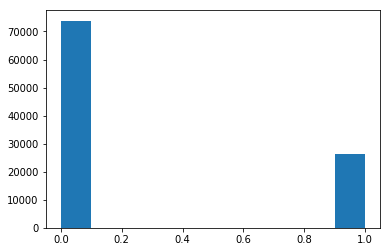

In [22]:
plt.hist(predictions)
plt.show()

The continuous valued predictions coming from our model tend to skew toward 0 or 1, but there is sufficient mass between 0.1 and 0.9 that adjusting the cutoff should indeed shift a number of customers' predictions.  For example...

In [23]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))

col_0,0,1
Fraud?_ True.,,
0,73844,3
1,3,26150


We can see that changing the cutoff from 0.5 to 0.3 results in 1 more true positives, 3 more false positives, and 1 fewer false negatives.  The numbers are small overall here, but that's 6-10% of customers overall that are shifting because of a change to the cutoff.  Was this the right decision?  We may end up retaining 3 extra customers, but we also unnecessarily incentivized 5 more customers who would have stayed.  Determining optimal cutoffs is a key step in properly applying machine learning in a real-world setting.  Let's discuss this more broadly and then apply a specific, hypothetical solution for our current problem.

### Relative cost of errors

Any practical binary classification problem is likely to produce a similarly sensitive cutoff. That by itself isn’t a problem. After all, if the scores for two classes are really easy to separate, the problem probably isn’t very hard to begin with and might even be solvable with simple rules instead of ML.

More important, if I put an ML model into production, there are costs associated with the model erroneously assigning false positives and false negatives. I also need to look at similar costs associated with correct predictions of true positives and true negatives.  Because the choice of the cutoff affects all four of these statistics, I need to consider the relative costs to the business for each of these four outcomes for each prediction.

#### Assigning costs

What are the costs for our problem of mobile operator churn? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, assign the true negatives the cost of \$0. Our model essentially correctly identified a happy customer in this case, and we don’t need to do anything.

False negatives are the most problematic, because they incorrectly predict that a churning customer will stay. We lose the customer and will have to pay all the costs of acquiring a replacement customer, including foregone revenue, advertising costs, administrative costs, point of sale costs, and likely a phone hardware subsidy. A quick search on the Internet reveals that such costs typically run in the hundreds of dollars so, for the purposes of this example, let's assume \$500. This is the cost of false negatives.

Finally, for customers that our model identifies as churning, let's assume a retention incentive in the amount of \$100. If my provider offered me such a concession, I’d certainly think twice before leaving. This is the cost of both true positive and false positive outcomes. In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will “waste” the \$100 concession. We probably could have spent that \$100 more effectively, but it's possible we increased the loyalty of an already loyal customer, so that’s not so bad.

#### Finding the optimal cutoff

It’s clear that false negatives are substantially more costly than false positives. Instead of optimizing for error based on the number of customers, we should be minimizing a cost function that looks like this:

```txt
$500 * FN(C) + $0 * TN(C) + $100 * FP(C) + $100 * TP(C)
```

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP.  We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this, is to simply run a simulation over a large number of possible cutoffs.  We test 100 possible values in the for loop below.

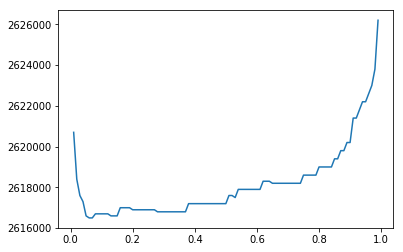

Cost is minimized near a cutoff of: 0.060000000000000005 for a cost of: 2616500


In [24]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 100], [500, 100]]) * 
                               pd.crosstab(index=test_data.iloc[:, 0], 
                                           columns=np.where(predictions > c, 1, 0)))))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

The above chart shows how picking a threshold too low results in costs skyrocketing as all customers are given a retention incentive.  Meanwhile, setting the threshold too high results in too many lost customers, which ultimately grows to be nearly as costly.  The overall cost can be minimized at \$8400 by setting the cutoff to 0.46, which is substantially better than the \$20k+ I would expect to lose by not taking any action.

---
## Extensions

This notebook showcased how to build a model that predicts whether a customer is likely to churn, and then how to optimally set a threshold that accounts for the cost of true positives, false positives, and false negatives.  There are several means of extending it including:
- Some customers who receive retention incentives will still churn.  Including a probability of churning despite receiving an incentive in our cost function would provide a better ROI on our retention programs.
- Customers who switch to a lower-priced plan or who deactivate a paid feature represent different kinds of churn that could be modeled separately.
- Modeling the evolution of customer behavior. If usage is dropping and the number of calls placed to Customer Service is increasing, you are more likely to experience churn then if the trend is the opposite. A customer profile should incorporate behavior trends.
- Actual training data and monetary cost assignments could be more complex.
- Multiple models for each type of churn could be needed.

Regardless of additional complexity, similar principles described in this notebook are likely apply.

### (Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)